# metabolic HMM
we are attempting to describe metabolic brain states with hidden Markov models.  To prove that this is feasible we are creating a toy model with two brain regions that are coupled.  We then define two states that correspond to different coupling coefficient.  To test the model, we will create a dataset from the model and then we will feed it into the analysis to see whether we can recreate the parameters from the data.

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import langevin

In [16]:
# transition matrix for states A and B
P=np.array([[0.99,0.01],[0.02,0.98]])
P1 = P[0,0]
P2 = P[1,0]
PA = P2/(P2+1-P1)
PB = 1 - PA
print(P1,P2,PA,PB)

# create a sample
firstpoint = np.random.choice(2, 1, p=[PA,PB])
sample = [firstpoint[0]]
for i in range(1,10000):
    sample = np.concatenate((sample,np.random.choice(2,1,p=P[sample[-1]])))

0.99 0.02 0.666666666667 0.333333333333


(-0.1, 1.1)

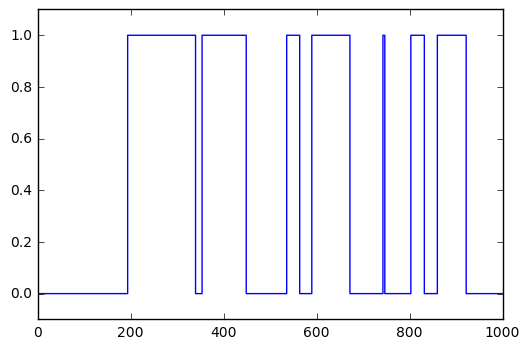

In [17]:
# plot the state variable
plt.plot(sample[:1000], drawstyle='steps-mid')
plt.ylim((-0.1,1.1))

In [18]:
print(not 1)

False


In [19]:
# to simulate the data we need to calculate the time intervals for each state
first = sample[0]
first_index = 0
intervals=[]
while first_index<len(sample):
    if first==0:
        first=1
    else:
        first=0
    try:
        change = next(i+first_index for i,state in enumerate(sample[first_index:]) if state==first)
    except:
        change = len(sample)
    intervals.append([first_index,change])
    first_index = change


(array([ 0.01142434,  0.00509464,  0.00169821,  0.00138945,  0.0009263 ,
         0.00046315,  0.        ,  0.        ,  0.00015438,  0.00030877]),
 array([   1. ,   47.6,   94.2,  140.8,  187.4,  234. ,  280.6,  327.2,
         373.8,  420.4,  467. ]),
 <a list of 10 Patch objects>)

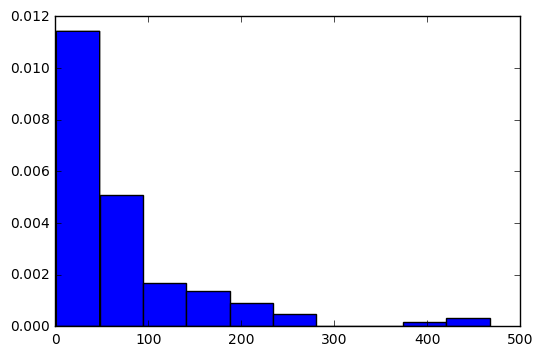

In [20]:
#print(intervals)
lengths=[interval[1]-interval[0] for interval in intervals]
plt.hist(lengths,normed=True)

In [21]:
#now we need to calculate the signal from the two brain regions
def time_series(A,D,delta_t,N):
    """ returns a time series that is the solution of a Langevin equation describing a Brownian particle in a harmonic potential
    :param A: mean square amplitude - oscillator strength
    :param D: Diffusion coefficient
    :param delta_t: time step
    :param N: number of samples that are returned
    :return:
    """
    # using Smolukowski solution for simulation

    #first point
    x=[np.random.normal(0,np.sqrt(A[0]))]
    stddev = np.sqrt(A * (1.0 - np.exp(-2.0 * D / A * delta_t)))

    for i in range(1,N):
        x.append(np.random.normal(x[-1]*np.exp(-D[i]/A[i]*delta_t),stddev[i]))

    return np.array(x)


In [22]:
# before we get to our more complicated model we create a one node model with different amplitudes
AA=np.array([0.1,1.0])
DD=np.array([1.0,1.0])
A=AA[sample]
D=DD[sample]
delta_t=0.2
simple_sample=time_series(A,D,delta_t,len(sample))

10000


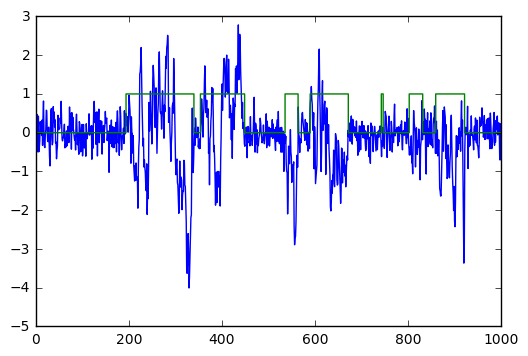

In [26]:
print(simple_sample.size)
plt.plot(simple_sample[:1000])
plt.plot(sample[:1000], drawstyle='steps-mid')


In [24]:
class HMMStates(pm.Categorical):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P1 : tensor
        probability to remain in state 1
    P2 : tensor
        probability to move from state 2 to state 1
    
    """

    def __init__(self, PA=None, P1=None, P2=None,
                 *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.PA = PA
        self.P1 = P1
        self.P2 = P2
        self.k = 2 # two state model
        self.mean = 0.
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        PA = self.PA
        P1 = self.P1
        P2 = self.P2
        
        # now we need to create an array with probabilities
        # so that for x=A: PA=P1, PB=(1-P1)
        # and for x=B: PA=P2, PB=(1-P2)
        # for more than two states we may use tt.choose()
#        length = x.shape[0]
        PT = tt.stack((P1,P2))
        
        P = PT[x[:-1]]
        
        x_i = x[1:]
        
        ou_like = pm.Categorical.dist(P, shape=(N_chain-1,2)).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)

In [ ]:
class HMMUhlenbeckOrnsteinEmissions(pm.Continuous):
    """
    Hidden Markov Model Gaussian Emissions
    Parameters
    ----------
    A : tensor
        prior for Gaussian emission mu
        shape = (2,N_states)
        
    S : tensor
        prior for Gaussian emission width
        shape = (2,N_states)
    
    states : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, A1=None, A2=None, D1=None, D2=None, delta_t=0.01, states=None,
                 *args, **kwargs):
        super(HMMUhlenbeckOrnsteinEmissions, self).__init__(*args, **kwargs)
        self.A1 = A1
        self.D1 = S1
        self.A2 = A2
        self.D2 = S2
        self.states = states
        self.mean = 0.

    def logp(self, x):
        A1 = self.A1
        D1 = self.D1
        A2 = self.A2
        D2 = self.D2
        states = self.states
        
#        length = x.shape[0]
#        AT = tt.tile(A.T,(length,1,1))
#        ST = tt.tile(S.T,(length,1,1))
        
#        AS = tt.switch(states,AT.T)        
#        SS = tt.switch(states,ST.T)
        AT = tt.stack((A1,A2))
        AS = AT[states]
        
        ST = tt.stack((S1,S2))
        SS = ST[states]
        
        ou_like = pm.Normal.dist(mu=AS,sd=SS).logp(x)
        return tt.sum(ou_like)